In [0]:
import h5py
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
import tensorflow as tf

from google.colab import drive
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.initializers import glorot_uniform
from keras.optimizers import Adam

sns.set()
warnings.filterwarnings("ignore")
drive.mount('/content/drive/')
print (tf.test.gpu_device_name())

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/device:GPU:0


# Data Preprocessing

**Data Preview**

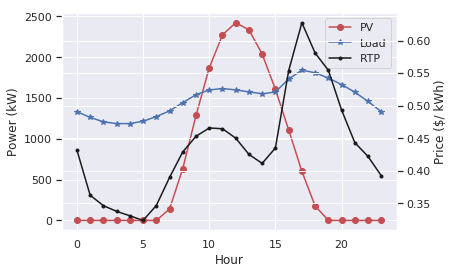

In [0]:
df_raw = pd.read_csv("/content/drive/My Drive/Colab/Research - Transactive Energy/Final Modified Data.csv")
df = df_raw.copy()

fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

PV_plot = ax.plot(df.iloc[0:24, 0], 'ro-', label = "PV")
load_plot = ax.plot(df.iloc[0:24, 1], 'b*-', label = "Load")
price_plot = ax2.plot(df.iloc[0:24, 2], 'k.-', label = "RTP")

# Show all label in one box
plots = PV_plot + load_plot + price_plot
labels = [plot.get_label() for plot in plots]
ax.legend(plots, labels, loc = 0)

ax.set_xlabel("Hour")
ax.set_ylabel("Power (kW)")
ax2.set_ylabel("Price ($/ kWh)")

plt.show()

**Standardization**

In [0]:
# StandardScaler

# The mean is not shifted to zero-centered
sc_price = StandardScaler(with_mean = False)
price = sc_price.fit_transform(df.iloc[:, 2:].values)

sc_energy = StandardScaler(with_mean = False)
pv = sc_energy.fit_transform(df.iloc[:, 0:1].values)
load = sc_energy.transform(df.iloc[:, 1:2].values)

x = np.concatenate([pv, load, price], axis = -1)

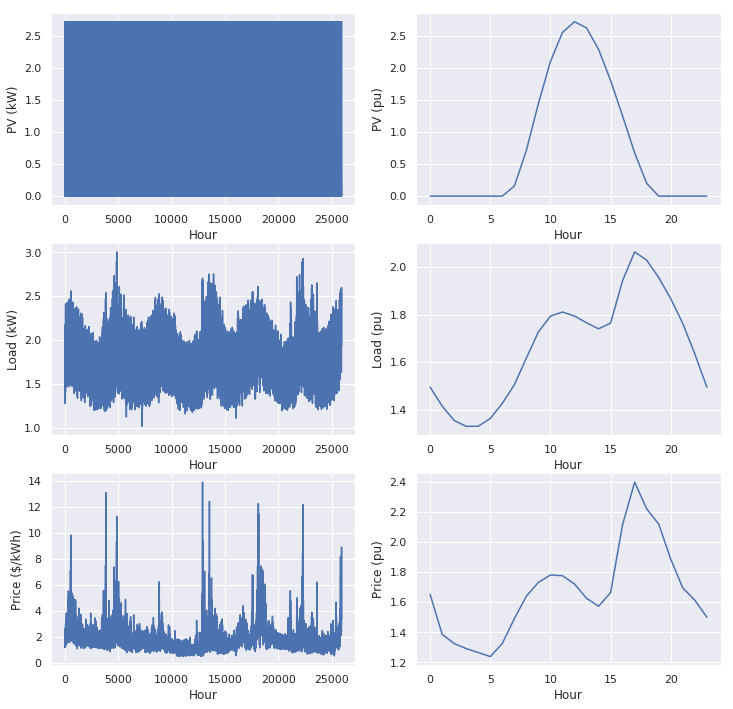

In [0]:
fig, ax = plt.subplots(3, 2, figsize = (12, 12))

ax[0, 0].plot(x[:, 0])
ax[0, 0].set_xlabel("Hour")
ax[0, 0].set_ylabel("PV (kW)")

ax[0, 1].plot(x[0:24, 0])
ax[0, 1].set_xlabel("Hour")
ax[0, 1].set_ylabel("PV (pu)")

ax[1, 0].plot(x[:, 1])
ax[1, 0].set_xlabel("Hour")
ax[1, 0].set_ylabel("Load (kW)")

ax[1, 1].plot(x[0:24, 1])
ax[1, 1].set_xlabel("Hour")
ax[1, 1].set_ylabel("Load (pu)")

ax[2, 0].plot(x[:, 2])
ax[2, 0].set_xlabel("Hour")
ax[2, 0].set_ylabel("Price ($/kWh)")

ax[2, 1].plot(x[0:24, 2])
ax[2, 1].set_xlabel("Hour")
ax[2, 1].set_ylabel("Price (pu)")
plt.show()

# Value Based

**Deep Q-Network Model**

In [0]:
class DQNNet():
  
  def __init__(self, state_size, action_size, learning_rate):
    
    self.state_size = state_size
    self.action_size = action_size
    self.learning_rate = learning_rate
    self.model = self.create_model()
    
  def create_model(self):
    
    #state_size = (5, ) 
    input = Input(shape = self.state_size)
    x = Dense(40, activation = "elu", 
              kernel_initializer = glorot_uniform(seed = 42))(input)
    x = Dense(160, activation = "elu",
              kernel_initializer = glorot_uniform(seed = 42))(x)
    output = Dense(self.action_size, activation = "linear", 
              kernel_initializer = glorot_uniform(seed = 42))(x)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss = "mse", optimizer = Adam(lr = self.learning_rate))
    model.summary()
    
    return model  

**Memory Model**

In [0]:
# A tree based array containing priority of each experience for fast sampling

class SumTree():
  
  """
  __init__ - create data array storing experience and a tree based array storing priority
  add - store new experience in data array and update tree with new priority
  update - update tree and propagate the change through the tree
  get_leaf - find the final nodes with a given priority value
  """

  data_pointer = 0

  def __init__(self, capacity):
    
    """
    capacity - Number of final nodes containing experience
    data - array containing experience (with pointers to Python objects)
    tree - a tree shape array containing priority of each experience

     tree:
        0
       / \
      0   0
     / \ / \
    0  0 0  0 
    """
    self.capacity = capacity
    self.data = np.zeros(capacity, dtype = object)
    self.tree = np.zeros(2 * capacity - 1)

  def add(self, priority, data):
    
    # Start from first leaf node of the most bottom layer
    tree_index = self.data_pointer + self.capacity - 1

    self.data[self.data_pointer] = data # Update data frame
    self.update(tree_index, priority) # Update priority

    # Overwrite if exceed memory capacity
    self.data_pointer += 1
    if self.data_pointer >= self.capacity:  
      self.data_pointer = 0

  def update(self, tree_index, priority):

    # Change = new priority score - former priority score
    change = priority - self.tree[tree_index] 
    self.tree[tree_index] = priority

    # Propagate the change through tree
    while tree_index != 0: 
      tree_index = (tree_index - 1) // 2
      self.tree[tree_index] += change

  def get_leaf(self, v):

    parent_index = 0

    while True:
      left_child_index = 2 * parent_index + 1
      right_child_index = left_child_index + 1
      # Downward search, always search for a higher priority node till the last layer
      if left_child_index >= len(self.tree):
        leaf_index = parent_index
        break
      else: 
        if v <= self.tree[left_child_index]:
          parent_index = left_child_index
        else:
          v -= self.tree[left_child_index]
          parent_index = right_child_index

    data_index = leaf_index - self.capacity + 1
      
    # tree leaf index, priority, experience
    return leaf_index, self.tree[leaf_index], self.data[data_index]

In [0]:
class Memory():  # stored as (s, a, r, s_) in SumTree
    
  """
  
  __init__ - create SumTree memory
  store - assign priority to new experience and store with SumTree.add & SumTree.update
  sample - uniformly sample from the range between 0 and total priority and 
           retrieve the leaf index, priority and experience with SumTree.get_leaf
  batch_update - update the priority of experience after training with SumTree.update
  
  PER_e - Hyperparameter that avoid experiences having 0 probability of being taken
  PER_a - Hyperparameter that allows tradeoff between taking only experience with 
          high priority and sampling randomly (0 - pure uniform randomness, 1 -
          select experiences with the highest priority)
  PER_b - Importance-sampling, from initial value increasing to 1, control how much
          IS affect learning
          
  """
  
  PER_e = 0.01 
  PER_a = 0.6
  PER_b = 0.4
  PER_b_increment_per_sampling = 0.01
  absolute_error_upper = 1.  # Clipped abs error

  def __init__(self, capacity):
    
    self.tree = SumTree(capacity)

  def store(self, experience):
    
    # Find the max priority
    max_priority = np.max(self.tree.tree[-self.tree.capacity:])

    # If the max priority = 0, this experience will never have a chance to be selected
    # So a minimum priority is assigned
    if max_priority == 0:
      max_priority = self.absolute_error_upper

    self.tree.add(max_priority, experience)

  def sample(self, n):

    """
    First, to sample a minibatch of k size, the range [0, priority_total] is
    divided into k ranges. A value is uniformly sampled from each range. Search 
    in the sumtree, the experience where priority score correspond to sample 
    values are retrieved from. Calculate IS weights for each minibatch element
    """

    b_memory = []
    b_idx = np.empty((n, ))
    b_ISWeights =  np.empty((n, 1))

    priority_segment = self.tree.tree[0] / n   

    self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])

    prob_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.tree[0]
    max_weight = (prob_min * n) ** (-self.PER_b)

    for i in range(n):
      a = priority_segment * i
      b = priority_segment * (i + 1)
      value = np.random.uniform(a, b)
      index, priority, data = self.tree.get_leaf(value)
      prob = priority / self.tree.tree[0]
      b_ISWeights[i, 0] = (prob * n) ** (-self.PER_b) / max_weight               
      b_idx[i]= index
      b_memory.append([data])

    return b_idx, b_memory, b_ISWeights

  def batch_update(self, tree_idx, abs_errors):
      
    # To avoid 0 probability
    abs_errors += self.PER_e 
    clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
    ps = np.power(clipped_errors, self.PER_a)

    for ti, p in zip(tree_idx, ps):
      self.tree.update(ti, p)

**Battery Model**

In [0]:
class Battery():
    
  def __init__(self, action_size, scaler_energy, scaler_price):
    
    """
    P_rated - charge/ discharge rate (kW)
    E_rated - rated capacity (kWh)
    C_E - energy capital cost ($/kWh)
    LC - life cycle
    eta - efficiency
    DOD - depth of discharge
    wear_cost - wear & operation cost ($/kWh/operation)
    wear_cost = (C_E * E_rated) / (eta * E_rated * LC * DOD)
    """ 
    self.P_rated = scaler_energy.transform(np.array([[1000]]))[0] # pu
    self.E_rated = scaler_energy.transform(np.array([[5000]]))[0] # pu 
    self.C_E = scaler_price.transform(np.array([[171]]))[0] # pu
    self.LC = 4996
    self.eta = 1.
    self.DOD = 1.
    self.wear_cost = self.C_E / self.eta / self.DOD / self.LC
    self.action_set = np.linspace(-1, 1, num = action_size, endpoint = True)
    self.initial_SOC = 0.
    
  def compute(self, state, action):
    
    current_pv = state[0]
    current_load = state[1]
    current_price = state[2]
    current_SOC = state[3]
    average_price = state[4]
    
    delta_SOC = self.action_set[action] * self.P_rated / self.E_rated
    
    if self.action_set[action] <= 0:
      next_SOC = np.maximum(0., current_SOC + delta_SOC)
      # Assign penalty if battery operates exceeding permissible limit
      if abs(delta_SOC) > current_SOC:
        penalty = 10
      else:
        penalty = 0
    else:
      next_SOC = np.minimum(1., current_SOC + delta_SOC)
      if abs(delta_SOC) > 1 - current_SOC:
        penalty = 10
      else:
        penalty = 0
    
    # Assign penalty to force containment of PV within the building
    if current_pv > (current_load + (next_SOC - current_SOC) * self.E_rated):
      penalty2 = 10
    else:
      penalty2 = 0

    energy_gain = average_price * next_SOC * self.E_rated  
    trading_cost = current_price * (current_load - current_pv \
                                    + (next_SOC - current_SOC) * self.E_rated)
    # trading_cost = current_price * (current_load + (next_SOC - current_SOC) * self.E_rated)    
    wear_cost = self.wear_cost * np.abs((next_SOC - current_SOC) * self.E_rated)
    
    # +ve - positive reward/ gain
    reward = energy_gain - trading_cost - wear_cost - penalty - penalty2
    
    return next_SOC, reward

**Hyperparameters Setting**

In [0]:
# DQN hyperparameters
state_size = (5, ) #PV, load, RTP, past 24 hour average RTP, SOC
action_size = 11
learning_rate = 0.001

# Training hyperparameters
batch_size = 64             

# Exploration hyperparameters for epsilon greedy strategy
explore_start = 1.0 # exploration probability at start
explore_stop = 0.01 # minimum exploration probability 
decay_rate = 0.0001 # exponential decay rate for exploration prob

# Q-learning hyperparameters
gamma = 0.95 # Discounting rate of future reward

# Memory hyperparameters
pretrain_length = 10000 # # of experiences stored in Memory during initialization
memory_size = 10000 # # of experiences Memory can keep

**Memory Initialization**

In [0]:
battery = Battery(action_size = action_size, 
                  scaler_energy = sc_energy, 
                  scaler_price = sc_price)

memory = Memory(memory_size)

np.random.seed(42)

# Memory initialization
SOC = np.array([battery.initial_SOC])
historical_price = np.zeros(24)
day = 0
hour = 0
done = False

for i in range(pretrain_length):
  
  # Keep track of the past 24 hours' electricity price
  historical_price[hour] = x[day * 24 + hour, 2]
  average_price = np.mean(np.array([price for price in historical_price if price != 0]))
  
  state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)
  action = np.random.randint(0, action_size)
  
  # Compute the reward and new state based on the selected action
  next_SOC, reward = battery.compute(state, action)
  
  # Store the experience in memory
  if hour < 23:
    hour += 1
    historical_price[hour] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))
    next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
  else:
    done = True
    day += 1
    hour = 0
    if day < len(x) / 24:
      historical_price[hour] = x[day * 24 + hour, 2]
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      break
      
  SOC = next_SOC
  experience = state, action, reward, next_state, done
  memory.store(experience) 

**DQN Training**

In [0]:
DQN = DQNNet(state_size = state_size, 
             action_size = action_size, 
             learning_rate = learning_rate)

decay_step = 0 # Decay rate for ϵ-greedy policy
SOC = np.array([battery.initial_SOC])
day = 0
hour = 0
done = False
hour_rewards = []
day_mean_rewards = []

while day < len(x) / 24:

  # Keep track of the past 24 hours' electricity price
  historical_price[hour] = x[day * 24 + hour, 2]
  average_price = np.mean(np.array([price for price in historical_price if price != 0]))
  
  state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)

  # ϵ-greedy policy        
  exp_exp_tradeoff = np.random.rand()
  explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
  if (explore_probability > exp_exp_tradeoff):
    action = np.random.randint(0, action_size)
  else:
    action = np.argmax(DQN.model.predict(np.expand_dims(state, axis = 0)))

  # Compute the reward and new state based on the selected action
  next_SOC, reward = battery.compute(state, action)  

  hour_rewards.append(reward)
  
  # Store the experience in memory
  if hour < 23:
    hour += 1
    historical_price[hour] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))
    next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
  else:
    done = True
    day += 1
    hour = 0
    if day < len(x) / 24:
      historical_price[hour] = x[day * 24 + hour, 2]
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      break
    mean_reward = np.mean(hour_rewards)
    day_mean_rewards.append(mean_reward)
    hour_rewards = []
    print("Day: {}".format(day),
          "Mean reward: {:.2f}".format(mean_reward),
          "Training loss: {:.2f}".format(loss),
          "Explore P: {:.2f} \n".format(explore_probability))  
  
  SOC = next_SOC 
  experience = state, action, reward, next_state, done
  memory.store(experience)
  decay_step +=1
  
  # DQN training            
  tree_idx, batch, ISWeights_mb = memory.sample(batch_size) # Obtain random mini-batch from memory

  states_mb = np.array([each[0][0] for each in batch])
  actions_mb = np.array([each[0][1] for each in batch])
  rewards_mb = np.array([each[0][2] for each in batch]) 
  next_states_mb = np.array([each[0][3] for each in batch])
  dones_mb = np.array([each[0][4] for each in batch])

  targets_mb = DQN.model.predict(states_mb)

  # Update those targets at which actions are taken
  target_batch = []
  q_next_state = DQN.model.predict(next_states_mb)
  for i in range(0, len(batch)):  
    action = np.argmax(q_next_state[i])
    if dones_mb[i] == 1:
      target_batch.append(rewards_mb[i])
    else:
      target = rewards_mb[i] + gamma * q_next_state[i][action]
      target_batch.append(rewards_mb[i])

  # Replace the original with the updated targets
  one_hot = np.zeros((len(batch), action_size))
  one_hot[np.arange(len(batch)), actions_mb] = 1
  targets_mb = targets_mb.astype("float64")
  target_batch = np.array([each for each in target_batch]).astype("float64")
  np.place(targets_mb, one_hot > 0, target_batch)

  loss = DQN.model.train_on_batch(states_mb, targets_mb, sample_weight = ISWeights_mb.ravel())

  # Update priority
  absolute_errors = []
  predicts_mb = DQN.model.predict(states_mb)
  for i in range(0, len(batch)):
    absolute_errors.append(np.abs(predicts_mb[i][actions_mb[i]] - targets_mb[i][actions_mb[i]]))
  absolute_errors = np.array(absolute_errors)

  tree_idx = np.array([int(each) for each in tree_idx])
  memory.batch_update(tree_idx, absolute_errors)
  
  # Save model every 5 days
  if day % 5 == 0:
    DQN.model.save_weights("/content/drive/My Drive/Colab/Research - Transactive Energy/DQN.hdf5")

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 40)                240       
_________________________________________________________________
dense_14 (Dense)             (None, 160)               6560      
_________________________________________________________________
dense_15 (Dense)             (None, 11)                1771      
Total params: 8,571
Trainable params: 8,571
Non-trainable params: 0
_________________________________________________________________
Day: 1 Mean reward: -3.76 Training loss: 0.82 Explore P: 1.00 

Day: 2 Mean reward: -5.86 Training loss: 0.30 Explore P: 1.00 

Day: 3 Mean reward: -1.75 Training loss: 0.16 Explore P: 0.99 

Day: 4 Mean reward: -1.13 Training loss: 0.18 Explore P: 0.99 


**Testing**

In [0]:
DQN.model.load_weights("/content/drive/My Drive/Colab/Research - Transactive Energy/DQN.hdf5")

SOC = np.array([battery.initial_SOC])
historical_price = np.zeros(24)
day = 0
hour = 0
done = False
SOC_list = []
action_list = []
reward_list = []
av_price_list = []

while day < len(x) / 24:
  
  historical_price[hour] = x[day * 24 + hour, 2]
  average_price = np.mean(np.array([price for price in historical_price if price != 0]))
  
  state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)
  action = np.argmax(DQN.model.predict(np.expand_dims(state, axis = 0)))
  
  next_SOC, reward = battery.compute(state, action)

  SOC = next_SOC
  SOC_list.append(SOC)
  reward_list.append(reward)
  action_list.append(action)
  av_price_list.append(average_price)  
  
  if hour < 23:
    hour += 1
    historical_price[hour] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))
    next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
  else:
    done = True
    day += 1
    hour = 0
    if day < len(x) / 24:
      historical_price[hour] = x[day * 24 + hour, 2]
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      break
  
print (np.mean(reward_list))

5.116808749400167


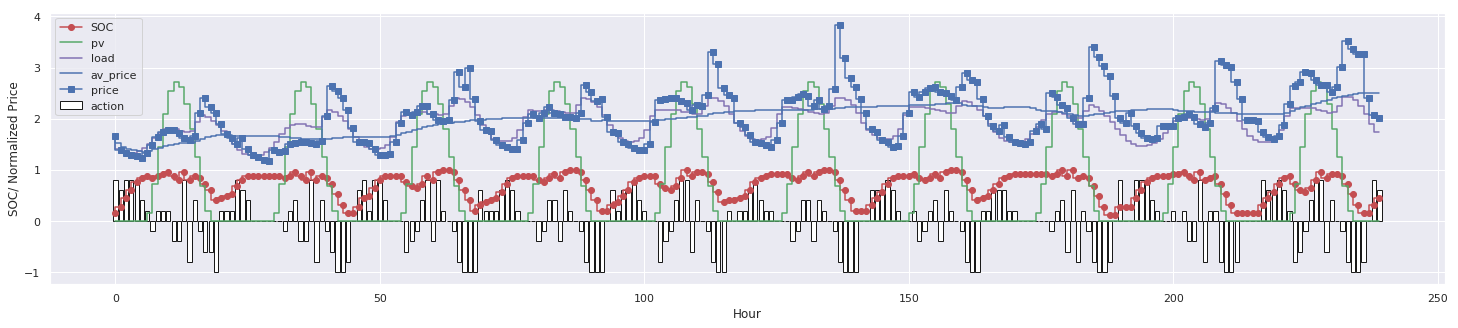

In [0]:
# First 10 days

i = 10

plt.figure(figsize = (25,5))
plt.step(range(0, 24 * i), SOC_list[0:24 * i], "ro-", label = "SOC")
plt.step(range(0, 24 * i), x[0:24 * i, 0], "g", label = "pv")
plt.step(range(0, 24 * i), x[0:24 * i, 1], "m", label = "load")
plt.step(range(0, 24 * i), av_price_list[0:24 * i], label = "av_price")
plt.step(range(0, 24 * i), x[0:24 * i, 2], "bs", label = "price")
plt.bar(range(0, 24 * i), battery.action_set[action_list[0:24 * i]], 
        facecolor = "w", edgecolor = "k", label = "action")
plt.ylabel("SOC/ Normalized Price")
plt.xlabel("Hour")
plt.legend()
plt.show()

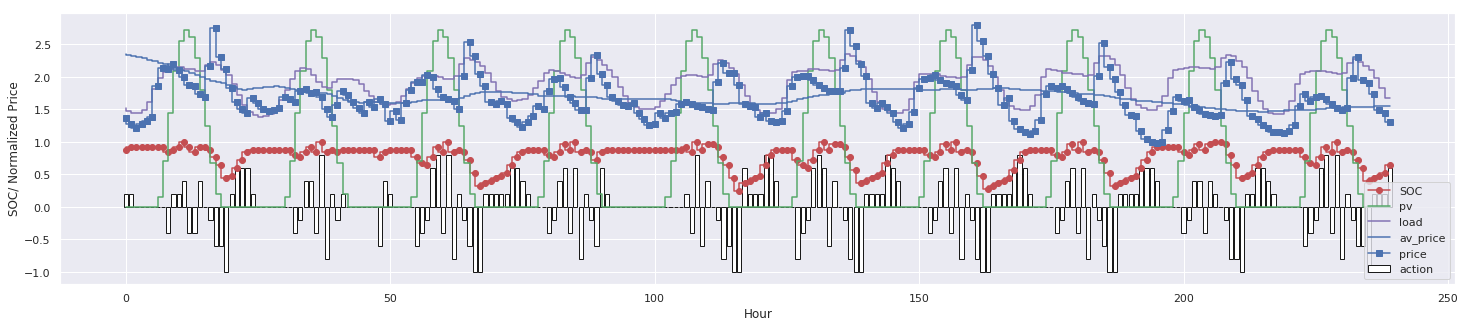

In [0]:
# Second last ten days

i = 10

plt.figure(figsize = (25,5))
plt.step(range(0, 24 * i), SOC_list[-24 * i * 2:-24 * i], "ro-", label = "SOC")
plt.step(range(0, 24 * i), x[-24 * i * 2:-24 * i, 0], "g", label = "pv")
plt.step(range(0, 24 * i), x[-24 * i * 2:-24 * i, 1], "m", label = "load")
plt.step(range(0, 24 * i), av_price_list[-24 * i * 2:-24 * i], label = "av_price")
plt.step(range(0, 24 * i), x[-24 * i * 2:-24 * i, 2], "bs", label = "price")
plt.bar(range(0, 24 * i), battery.action_set[action_list[-24 * i * 2:-24 * i]], 
        facecolor = "w", edgecolor = "k", label = "action")
plt.ylabel("SOC/ Normalized Price")
plt.xlabel("Hour")
plt.legend()
plt.show()

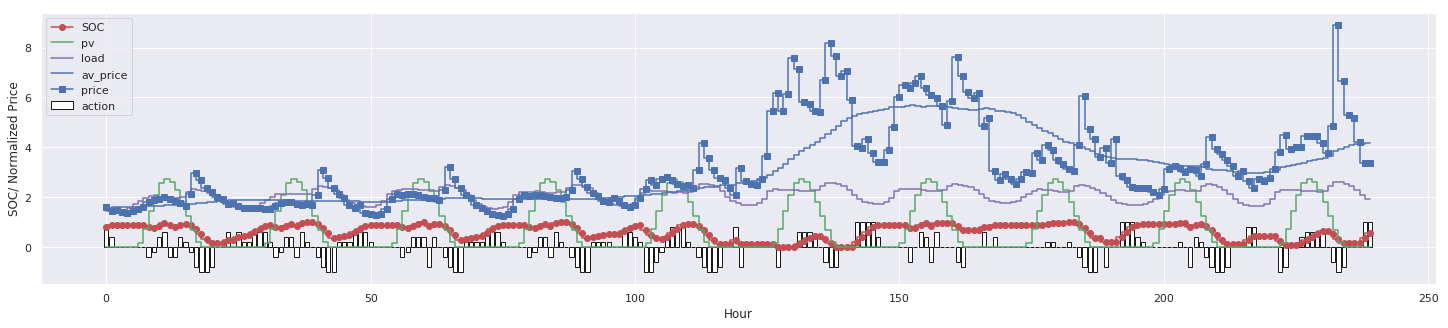

In [0]:
# Last ten days

i = 10

plt.figure(figsize = (25,5))
plt.step(range(0, 24 * i), SOC_list[-24 * i:], "ro-", label = "SOC")
plt.step(range(0, 24 * i), x[-24 * i:, 0], "g", label = "pv")
plt.step(range(0, 24 * i), x[-24 * i:, 1], "m", label = "load")
plt.step(range(0, 24 * i), av_price_list[-24 * i:], label = "av_price")
plt.step(range(0, 24 * i), x[-24 * i:, 2], "bs", label = "price")
plt.bar(range(0, 24 * i), battery.action_set[action_list[-24 * i:]], 
        facecolor = "w", edgecolor = "k", label = "action")
plt.ylabel("SOC/ Normalized Price")
plt.xlabel("Hour")
plt.legend()
plt.show()

In [0]:
"""
trading_cost - cost buying/ selling from/ to grid
operation_cost - wear cost of battery resulting from operation
"""

# Without ESS
trading_cost_WOESS = -sc_price.inverse_transform(x[:, 2:]) \
                     * sc_energy.inverse_transform(x[:, 1:2] - x[:, 0:1])
total_cost_WOESS = trading_cost_WOESS

# With ESS
trading_cost = -sc_price.inverse_transform(x[:,2:]) \
               * sc_energy.inverse_transform((x[:, 1:2] - x[:, 0:1] \
                                              + np.expand_dims((battery.action_set[action_list] \
                                                                * battery.P_rated), axis = -1)))
operation_cost = -sc_price.inverse_transform(battery.wear_cost) \
                 * sc_energy.inverse_transform(np.abs(np.expand_dims((battery.action_set[action_list] \
                                                                      * battery.P_rated), axis = -1)))
total_cost = trading_cost + operation_cost

print ("Cost without ESS: {:0.2f}".format(np.sum(total_cost_WOESS)))
print ("Cost with ESS: {:0.2f}".format(np.sum(total_cost)))
print ("Net benefit: {:0.2f}".format(np.sum(total_cost) - np.sum(total_cost_WOESS)))
print ("Daily mean cost without ESS: {:0.2f}".format(np.sum(total_cost_WOESS) / (len(x) / 24 )))
print ("Daily mean cost with ESS: {:0.2f}".format(np.sum(total_cost) / (len(x) / 24 )))
print ("Daily net benefit: {:0.2f}".format((np.sum(total_cost) - np.sum(total_cost_WOESS)) / (len(x) / 24 )))

Cost without ESS: -11713917.68
Cost with ESS: -11419031.11
Net benefit: 294886.57
Daily mean cost without ESS: -10836.19
Daily mean cost with ESS: -10563.40
Daily net benefit: 272.79
